In [1]:
# Загрузка необходимых библиотек
# pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# from pyimage.convnet import ConvNet
# from pyimage.preprocessor import Preprocessor
# from pyimage.datasetloader import DatasetLoader

# !pip install imutils
from imutils import paths 

In [2]:
# Создание вспомогательного класса для изменения размеров изображения
class Preprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter
  
    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [3]:
# Создание вспомогательного класса для загрузки данных (изображения. метки)
class DatasetLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths):
        data = []
        labels = []
        for image_path in imagePaths:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = image_path.split(os.path.sep)[-2]
            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)
                    
            data.append(image)
            labels.append(label)
        return (np.array(data), np.array(labels))  

In [7]:
# Создание класса свёрточной нейронной сети 
# INPUT => CONV64 => RELU => POOL => CONV128 => RELU => POOL => FC500 => RELU => FC3 => SOFTMAX
class ConvNet: 
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)

        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(500, activation='relu'))

        model.add(Dense(classes, activation='softmax'))
        return model

In [17]:
# Создание класса свёрточной нейронной сети
# INPUT => CONV64 => RELU => POOL => CONV128 => RELU => POOL => CONV64 => RELU => POOL => FC500 => RELU => FC3 => SOFTMAX
class ConvNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)

        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))

        model.add(Dense(classes, activation='softmax'))
        return model

In [24]:
# Создание класса свёрточной нейронной сети
# INPUT => CONV32 => RELU => POOL => CONV64 => RELU => POOL => CONV128 => RELU => POOL => FC500 => RELU => FC3 => SOFTMAX
class ConvNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)

        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))

        model.add(Dense(classes, activation='softmax'))
        return model

In [4]:
# Создание класса свёрточной нейронной сети
# INPUT => CONV32 => RELU => BN => POOL => DO => CONV64 => RELU => BN => POOL => DO => 
# => CONV128 => RELU => BN => POOL => DO => FC500 => RELU => BN => DO => FC3 => SOFTMAX
class ConvNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)

        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes, activation='softmax'))
        return model

In [5]:
# Функция для вывода случайных 24 изображений
def visual(x_train, y_train):
    index = np.random.choice(np.arange(len(x_train)), 24, replace=False)
    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))

    for item in zip(axes.ravel(), x_train[index], y_train[index]):
        axes, image, target = item
        axes.imshow(image)
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(target)
    plt.show()

In [6]:
# Функция для вывода неправильных прогнозов
def incorrect(x_test, y_test, pred):
    food = ('meat', 'dessert', 'bread', 'soup')
    incorrect_predictions = []

    for i, (p, e) in enumerate(zip(pred, y_test)):
        predicted, expected = np.argmax(p), np.argmax(e)
        if predicted != expected:
            incorrect_predictions.append((i, x_test[i], predicted, expected))
    print(len(incorrect_predictions))

    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))
    for item in zip(axes.ravel(), incorrect_predictions):
        axes, inc_pred = item
        axes.imshow(inc_pred[1])
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(f'p: {food[inc_pred[2]]}; e: {food[inc_pred[3]]}')
    plt.show()

    confusion = tf.math.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    print(confusion)

In [7]:
# Функция для вывода графиков зависимостей функции потерь и точности от номера эпохи
def visual_incorrect(epochs, hist):
    N = np.arange(0, epochs)
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(N, hist.history['loss'], label='Training Loss')
    plt.plot(N, hist.history['val_loss'], label='Validation Loss')
    plt.plot(N, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(N, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

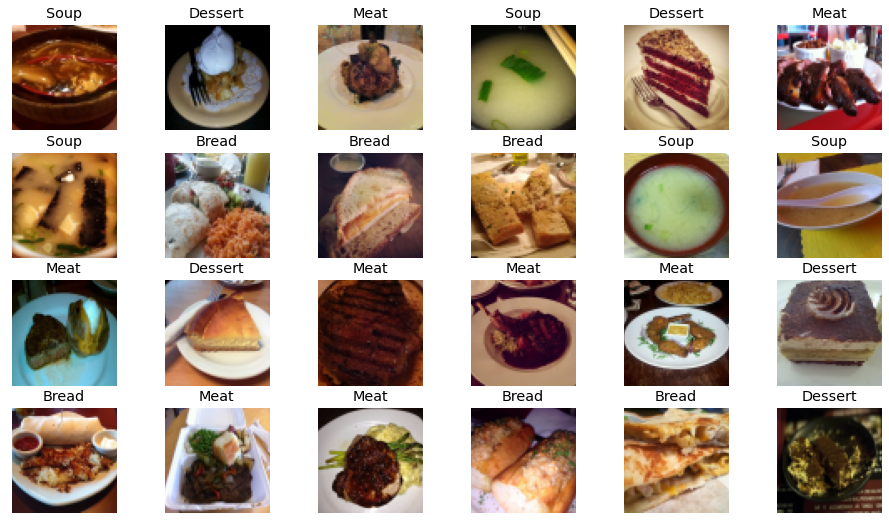

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 64)       

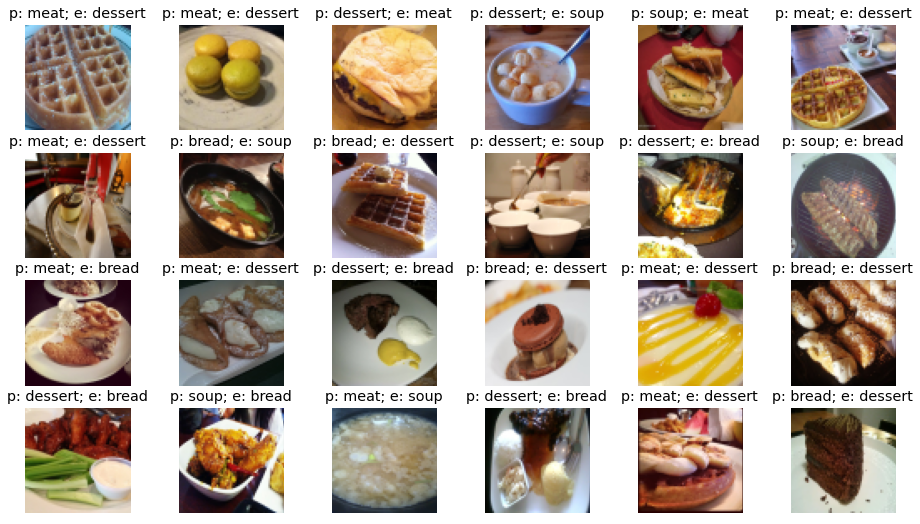

tf.Tensor(
[[354  70  70  23]
 [112 224  97  29]
 [ 51  80 379  13]
 [ 52  48  45 298]], shape=(4, 4), dtype=int32)


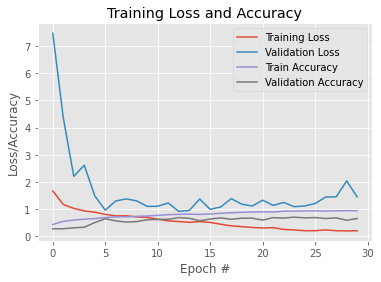

In [35]:
# Запускать ячейку, если аугментация данных не нужна

image_paths = list(paths.list_images(r'C:\Users\Formidable\Food'))
random.seed(1)
random.shuffle(image_paths)

input_width = 64
sp = Preprocessor(input_width, input_width)
dsl = DatasetLoader(preprocessors=[sp])
(data, labels) = dsl.load(image_paths)
data = data.astype('float32') / 255

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3, random_state=1)
visual(x_train, y_train)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

num_classes = 4
num_channels = 3
model = ConvNet.build(input_width, input_width, num_channels, num_classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 30
H = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

predictions = model.predict(x_test)

print(y_test[0])
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

incorrect(x_test, y_test, predictions)
visual_incorrect(epochs, H)

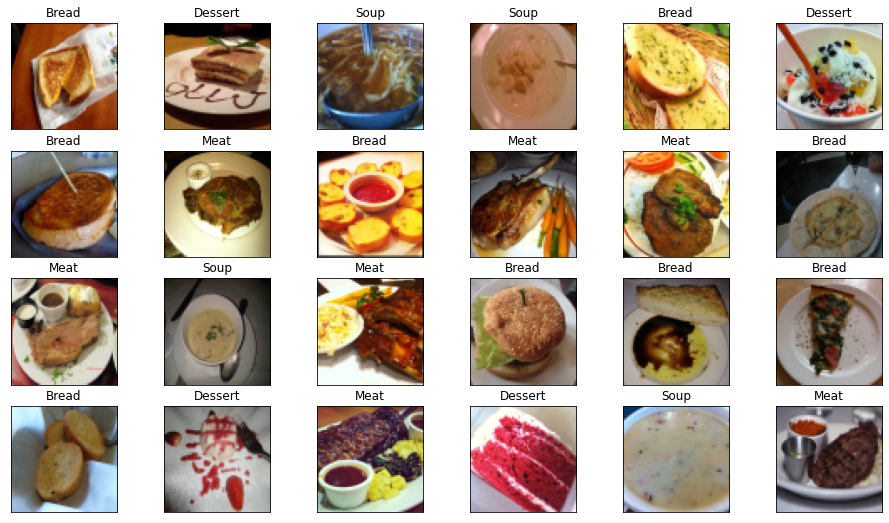

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

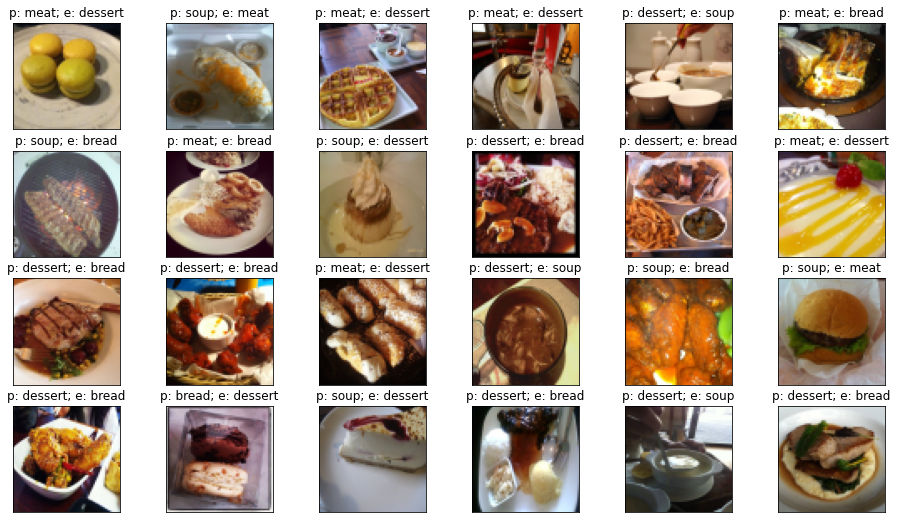

tf.Tensor(
[[368  73  27  49]
 [ 66 285  37  74]
 [ 55 119 326  23]
 [ 19  20  10 394]], shape=(4, 4), dtype=int32)


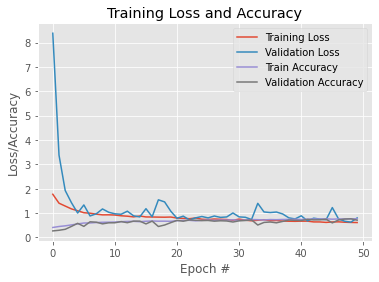

In [8]:
# Запускать ячейку, если нужна генерация данных

image_paths = list(paths.list_images(r'C:\Users\Formidable\Food'))
random.seed(1)
random.shuffle(image_paths)

input_width = 64
sp = Preprocessor(input_width, input_width)
dsl = DatasetLoader(preprocessors=[sp])
(data, labels) = dsl.load(image_paths)
data = data.astype('float32') / 255

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3, random_state=1)
visual(x_train, y_train)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode='nearest')

num_classes = 4
num_channels = 3
model = ConvNet.build(input_width, input_width, num_channels, num_classes)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
H = model.fit(aug.flow(x_train, y_train), epochs=epochs, validation_data=(x_test, y_test))

predictions = model.predict(x_test)

print(y_test[0])
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

incorrect(x_test, y_test, predictions)
visual_incorrect(epochs, H)